In [42]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
from scipy import stats

from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import VotingClassifier

# Evaluation Procedures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [43]:
rare_AD = pd.read_csv('../Data/data_gc_homo_poly_unique_1319.csv')

In [44]:
pheno = pd.read_csv('../Data/phenotypes_1319.csv',sep=';')

Scarto gli artefatti

In [45]:
rare_AD.drop(columns=['ARSD_0', 'ARSD_1', 'ARSD_2', 'VCX_1','VCX2_1'], inplace=True, axis=1)
len(rare_AD.columns)

12947

Scarto le mutazioni che terminano con `_0`

In [46]:
#todrop = rare_AD.columns[rare_AD.columns.str.contains('_0')].tolist()
#rare_AD.drop(columns=todrop, inplace=True)
#len(rare_AD.columns)

In [47]:
12947-7607

5340

Rimuovo i geni del cromosoma X

In [48]:
chr_X = pd.read_csv('../Data/Male/genes_chrX.csv')
genes_X = np.intersect1d(chr_X['genes_x'].tolist(), rare_AD.columns.tolist())
genes_X = chr_X['genes_x'].tolist()

In [49]:
selected = []
for x in rare_AD.columns:
    gene = x.split('_')[0]
    if gene in chr_X['genes_x'].tolist():
        selected.append(x)

In [50]:
rare_AD.drop(columns=selected, inplace=True)
len(rare_AD.columns)

12697

Filtro per etnia

In [51]:
#pheno['Ethnicity'] = pheno['Ethnicity (white=1, black=2, asian=3, hispanic=4)']
#pheno = pheno[(pheno['Ethnicity']=='1') | (pheno['Ethnicity'].isna())]

Mantengo solo pazienti con un grading

In [52]:
pheno = pheno[pheno['grading_1319_adj_a_s'].notna()]

Scarto pazienti senza età

In [53]:
pheno = pheno[pheno['Age'].notna()]

Cambio l'indice dei pazienti

In [54]:
pheno.rename(columns={"UsedSampleCode":"key"}, inplace=True)
pheno.set_index('key',inplace=True)

Scarto pazienti non corrispondenti

In [55]:
rare_AD.rename(columns={"Unnamed: 0": "key"}, inplace=True)
rare_AD.set_index('key',inplace=True)

rare_AD = rare_AD[rare_AD.index != 'COV2925-1241_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2928-1242_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3204-1334_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3196-1326_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2735-1159_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3211-1341_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2233-939_hg38']

rare_AD.index = rare_AD.index.str.replace('_hg38','')

In [56]:
grading = pheno[['grading_1319_adj_a_s','Gender (M=0, F=1)']]

df = rare_AD.join(grading, on='key')
df.rename(columns={'grading_1319_adj_a_s':'grading'}, inplace=True)

df

,AADACL3_0,ABCA4_0,ABCA4_1,ABL2_0,ACBD3_1,ACKR1_0,ACKR1_1,ACTL8_1,ACTN2_1,ACTRT2_0,...,DHRSX_2,DHRSX_3,DHRSX_4,GTPBP6_0,IL3RA_0,P2RY8_0,PLCXD1_0,SLC25A6_0,grading,"Gender (M=0, F=1)"
key,,,,,,,,,,,,,,,,,,,,,
AR-COV-10,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0.0
AR-COV-11,0,0,0,0,0,0,1,1,1,0,...,1,0,0,0,0,0,0,0,1,1.0
AR-COV-12,0,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,none,0.0
AR-COV-13,0,0,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0.0
AR-COV-14,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VE101,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,1.0
VE10,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.0
VE97,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,none,1.0


Mantengo solo le femmine

In [57]:
df = df[df['Gender (M=0, F=1)']==0].iloc[:,:-1]

df = df[df['grading']!='none']
df.dropna(inplace=True)

In [58]:
#df.drop(columns=value_counts[value_counts['percentage of 1'] > 90].mutation, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df.reset_index(inplace=True)

In [59]:
df.drop(columns='key',inplace=True)

In [60]:
df

,AADACL3_0,ABCA4_0,ABCA4_1,ABL2_0,ACBD3_1,ACKR1_0,ACKR1_1,ACTL8_1,ACTN2_1,ACTRT2_0,...,DHRSX_1,DHRSX_2,DHRSX_3,DHRSX_4,GTPBP6_0,IL3RA_0,P2RY8_0,PLCXD1_0,SLC25A6_0,grading
0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
487,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
488,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
489,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


Scarto le mutazioni non informative

In [61]:
value_counts = df.apply(pd.Series.value_counts)
value_counts = value_counts.transpose()
value_counts.columns = value_counts.columns.astype(str)
value_counts = value_counts.reset_index()
value_counts.rename(columns={'index':'mutation'}, inplace=True)
value_counts['percentage of 1'] = value_counts.apply(lambda row : row['1']/(len(df)), axis=1)

In [62]:
df.drop(columns=value_counts[value_counts['0'] >= len(df)].mutation, inplace=True)
df.drop(columns=value_counts[value_counts['1'] >= len(df)].mutation, inplace=True)

# Optimizing Lasso Classification 

In [63]:
target_variable = 'grading'
input_variables = df.columns[df.columns!=target_variable]

X = df[input_variables]
X.columns += '_homo'
y = df[target_variable]
X_nic = pd.read_csv('../Data/Male/X_GC_homo_male_antonio.csv', sep=';')
X_nic.drop(columns='Unnamed: 0', inplace=True)
y_nic = pd.read_csv('../Data/Male/y_GC_homo_male_antonio.csv', sep=';')['0']

In [64]:
len(X_nic.columns.tolist())

12376

In [65]:
len(X_nic.columns.tolist()) - len(X.columns.tolist())

0

In [66]:
np.setdiff1d(X_nic.columns.tolist(), X.columns.tolist())

array([], dtype='<U33')

In [67]:
print("Class %2d  %.1f%%\nClass %2d  %.1f%%\n"%((y.value_counts()/y.shape[0]).index[0],100*(y.value_counts()/y.shape[0]).values[0],(y.value_counts()/y.shape[0]).index[1],100*(y.value_counts()/y.shape[0]).values[1]))

Class  0  51.7%
Class  1  48.3%



In [68]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size= 0.9, random_state=1234, shuffle=True)

crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

In [69]:
c = np.logspace(np.log10(1e-2), np.log10(1e3), 51)

In [70]:
lasso = LogisticRegression(random_state=1234, solver="liblinear",penalty='l1',verbose=1)
parameters = {'C':c}
lasso_gs = GridSearchCV(lasso, parameters, n_jobs=-1, cv=crossvalidation, scoring='roc_auc')
lasso_gs.fit(X_nic,y_nic)

[LibLinear]

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=1234,
                                          solver='liblinear', verbose=1),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
       2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
       6.30957344e-02, 7.94328235e-02, 1...
       6.30957344e+00, 7.94328235e+00, 1.00000000e+01, 1.25892541e+01,
       1.58489319e+01, 1.99526231e+01, 2.51188643e+01, 3.16227766e+01,
       3.98107171e+01, 5.01187234e+01, 6.30957344e+01, 7.94328235e+01,
       1.00000000e+02, 1.25892541e+02, 1.58489319e+02, 1.99526231e+02,
       2.51188643e+02, 3.16227766e+02, 3.98107171e+02, 5.01187234e+02,
       6.30957344e+02, 7.94328235e+02, 1.00000000e+03])},
             scoring='roc_auc')

In [71]:
s = {'score':lasso_gs.cv_results_['mean_test_score'],'std':lasso_gs.cv_results_['std_test_score'],'c':1/c}
scores = pd.DataFrame(data=s)

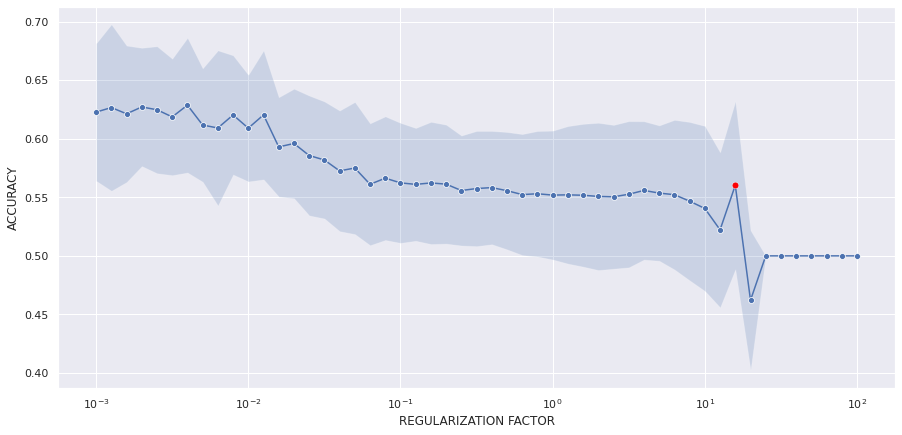

In [72]:
sns.set_theme()
plt.figure(figsize=(15,7))
ax = sns.lineplot(data=scores, x='c', y='score', ci=scores.std, markers=True, marker='o')
ax.fill_between(1/parameters['C'], y1=lasso_gs.cv_results_['mean_test_score'] - lasso_gs.cv_results_['std_test_score'], 
                y2=lasso_gs.cv_results_['mean_test_score'] + lasso_gs.cv_results_['std_test_score'], alpha=.2)
ax.set_xscale('log')
ax.set_ylabel('ACCURACY')
ax.set_xlabel('REGULARIZATION FACTOR')
#ax.set_title('Lasso LogisticRegression GridSearch')
plt.plot(1/c[8],s['score'][8], 'ok', markersize=5, color='red')
plt.savefig('./Plots/GS_GC_homo_male.png', dpi=150)
#ax.set_ylim([0.475,0.7])

In [73]:
lasso_gs.best_estimator_

LogisticRegression(C=251.18864315095823, penalty='l1', random_state=1234,
                   solver='liblinear', verbose=1)

In [74]:
1/c[8]

15.848931924611133

In [75]:
method_name = 'Lasso'

#lasso = lasso_gs.best_estimator_
lasso = LogisticRegression(C=c[8], penalty='l1', random_state=5, solver='liblinear', verbose=1)

xval_score = cross_val_score(lasso,X,y,cv=crossvalidation)

# compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)

lasso.fit(X,y)

importances = lasso.coef_

prec = np.average(cross_val_score(lasso,X,y,cv=crossvalidation, scoring='precision'))
    
rec = np.average(cross_val_score(lasso,X,y,cv=crossvalidation, scoring='recall'))
    
f1_metric = np.average(cross_val_score(lasso,X,y,cv=crossvalidation, scoring='f1'))
    
auc_metric = np.average(cross_val_score(lasso,X,y,cv=crossvalidation, scoring='roc_auc'))


print('\n')    
print("%40s"%method_name)
print("========================================")
print("\t  Accuracy (CV) %.3f %.3f"%(np.average(xval_score),np.std(xval_score)))
print("\tAccuracy (Test) %.3f"%accuracy_score(y_test, lasso.predict(X_test)))
print("\t      Precision %.3f"%prec)
print("\t      Recall    %.3f"%rec)
print("\t      F1        %.3f"%f1_metric)
print("\t      AUC        %.3f"%auc_metric)
print("\n")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

                                   Lasso
	  Accuracy (CV) 0.597 0.056
	Accuracy (Test) 0.500
	      Precision 0.663
	      Recall    0.363
	      F1        0.462
	      AUC        0.580




In [76]:
importances = lasso.coef_.flatten()
importances.shape[0]

12376

In [77]:
indices = np.argsort(np.absolute(importances))[::-1]#[0:100]
indices = indices[np.absolute(importances[indices])>0.000001]

In [78]:
selected_features = importances[indices]

In [79]:
len(selected_features)

11

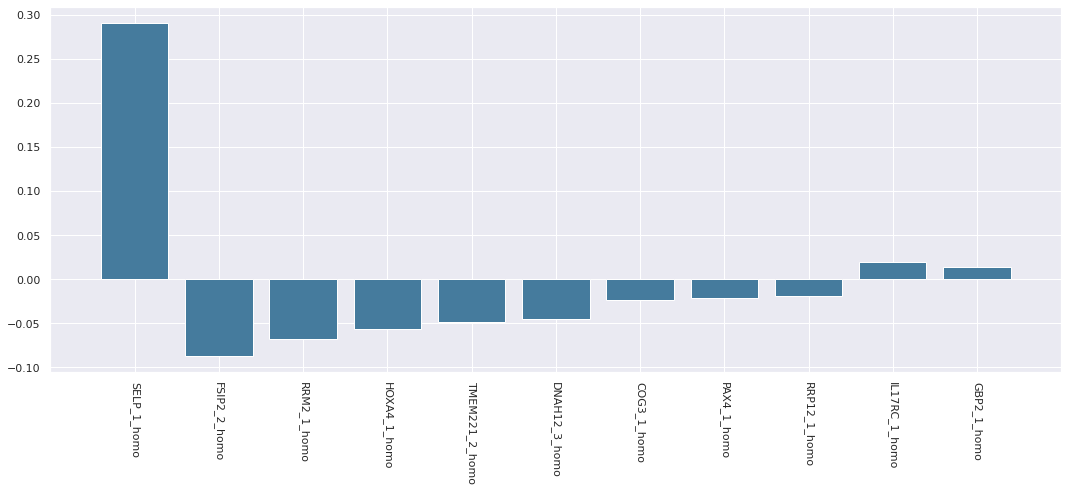

In [80]:
n_features = len(selected_features)

fig, ax = plt.subplots(figsize=(15,7))

#plt.title("Lasso Feature importances female rare AD")

ax.bar(range(n_features), importances[indices],
        color="#457b9d", yerr=None, align="center")

plt.xticks(range(n_features), X.columns[indices],rotation='-90')
#ax.get_xticklabels()[1].set_fontweight("bold")
#ax.get_xticklabels()[4].set_fontweight("bold")
#ax.get_xticklabels()[16].set_fontweight("bold")

plt.xlim([-1, len(selected_features)])#X.shape[1]])
plt.tight_layout()
#plt.savefig('./Plots/Feature_importances_adjbyage.png',dpi=150)
plt.savefig('./Plots/Selected_GC_homo_male.png', dpi=150)
plt.show()

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

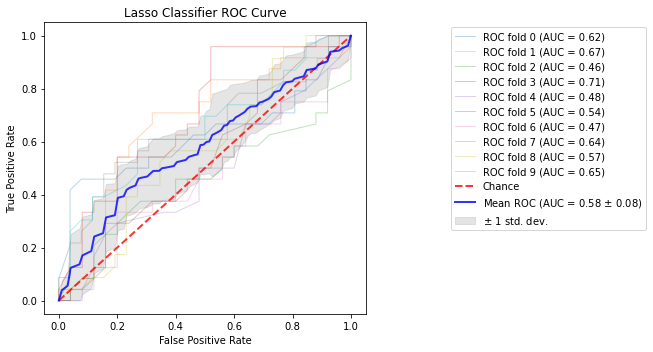

In [116]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,5))
for i, (train, test) in enumerate(crossvalidation.split(X, y)):
    lasso.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(lasso, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Lasso Classifier ROC Curve")
ax.legend(bbox_to_anchor=(1.25, 1.0))
plt.tight_layout()
#plt.savefig('./Plots/Lasso Adjusted by age ROC.png',dpi=150)
plt.show()

In [103]:
yp_cv = cross_val_predict(lasso, X, y, cv=crossvalidation)
tn, fp, fn, tp = confusion_matrix(y, yp_cv).ravel()

#tn, fp, fn, tp = confusion_matrix(y_test, yp).ravel()

conf = [[tn,fn],[fp,tp]]

confusion = np.array(conf)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

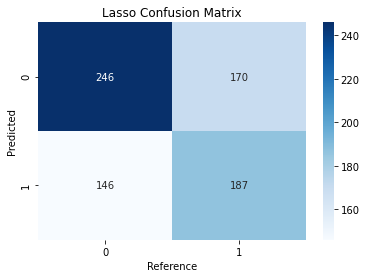

In [68]:
ax = sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g')
ax.set_ylabel('Predicted')
ax.set_xlabel('Reference')
ax.set_title('Lasso Confusion Matrix')
#ax.set_xticklabels(['Absent','Present'])
#ax.set_yticklabels(['Absent','Present'])
plt.savefig('./Plots/Lasso Confusion matrix adj by age.png', dpi=150)

In [97]:
selected_features = X.columns[indices]

In [99]:
df_out = df.loc[:, selected_features]
df_out['grading'] = df['grading']
df_out.to_csv('./selected_features_adjusted_by_age.csv',index=False)

# Confronto tra le nuove features selezionate e le precedenti

In [66]:
old_features = pd.read_csv('./selected_features_lasso_noindex.csv')

In [67]:
print('Le nuove features sono '+str(len(df_out.columns))+':')
print(df_out.columns.values)
print('\n')
print('Le vecchie features sono'+str(len(old_features.columns.values))+':')
print(old_features.columns.values)
print('\n')

common_features = np.intersect1d(df_out.columns.values,old_features.columns.values)

print('Le features in comune sono'+str(len(common_features))+':')
print(common_features)

Le nuove features sono 45:
['GYPB' 'MICAL1' 'KRTAP5-10' 'CSMD3' 'TMEM14B' 'MAGOHB' 'COL6A3' 'CEL'
 'MYO18B' 'ZNF714' 'FMN2' 'MYO7A' 'BOP1' 'ADAMTS10' 'ANKRD11' 'CNOT2'
 'ADAMTSL2' 'URB1' 'CELA1' 'TICRR' 'LY75;LY75-CD302' 'NUP153' 'CACNA1B'
 'OR4E2' 'NPIPB3' 'SH3BGRL2' 'MAPKAP1' 'STKLD1' 'APOB' 'IRF8' 'PKD1'
 'ARID1B' 'FNBP4' 'ADGRV1' 'CHN1' 'RAI1' 'AR' 'TAF4' 'DMKN' 'THAP11'
 'DRICH1' 'DCHS1' 'VPS13B' 'PILRB' 'lung']


Le vecchie features sono57:
['hypertension' 'MUC12' 'diabetes' 'RFTN2' 'CACNA1B' 'TTTY23;GYG2P1'
 'BOP1' 'TP53BP2;GTF2IP20' 'KRTAP5-10' 'MEX3C' 'ZNF419' 'OTOG' 'RPS6KA5'
 'NPIPB3' 'Autoimmune disease' 'AK9' 'APLP2' 'GXYLT1' 'COL6A6' 'MROH9'
 'SASH1' 'ZNF714' 'HSPG2' 'CCDC173' 'RAB11FIP1' 'RBM6' 'KRT1' 'AVPR1B'
 'DYNC2H1' 'REXO1' 'TAF4' 'STARD9' 'TMEM14B' 'SLC3A2' 'PIEZO1' 'WDR36'
 'C19orf57' 'DST' 'FMN2' 'FLNB' 'CRCP' 'ATN1' 'PLK5' 'SLAMF8' 'NSD2'
 'TMEM154' 'DCAF8L2' 'MST1' 'ADAMTS10' 'LAMA5' 'XIRP2' 'BRCA2' 'CEP290'
 'PPP1R3A' 'AR' 'NACA' 'lung']


Le features in comun

# Comparing with other methods after features selection

In [ ]:
target_variable = 'grading'
input_variables = selected_features

X = df[input_variables]
y = df[target_variable]

In [ ]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size= 0.9, random_state=1234, shuffle=True)

crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

In [ ]:
#n_estimators = 100
#max_depth = 5

n_estimators = 100
max_depth = 5

methods = {
    'Ridge':LogisticRegression(penalty="l2",C=0.1, random_state=1234, max_iter=300, solver="liblinear",class_weight='balanced'),
    'k-NN(5)':KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree'),
    'Decision Tree':DecisionTreeClassifier(max_depth=10,class_weight='balanced'),
    'Bagging(Tree)':BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth, class_weight='balanced'),n_estimators=n_estimators,
                                     random_state=1234),
    'Random Forest':RandomForestClassifier(n_estimators=n_estimators,max_depth=None,oob_score=True, class_weight='balanced',random_state=1234),
    'Extremely Randomized Trees':ExtraTreesClassifier(n_estimators=n_estimators,max_depth=max_depth, class_weight='balanced',random_state=1234),
    'Ada Boost':AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,class_weight='balanced'),n_estimators=n_estimators,random_state=1234)
}

In [ ]:
xval_results = {}
roc_results = {}
feature_importance_model = {}

method = []
accuracy_mean = []
accuracy_std = []
precision = []
recall = []
f1 = []
auc_scores =[]

for method_name in methods:
    
    
    clf = methods[method_name];
    
    # evaluate the model using crossvalidation
    xval_score = cross_val_score(clf,X,y,cv=crossvalidation)
    
    # store the raw results of crossvalidation that we might want to use for t-test/mann-whitney comparison
    xval_results[method_name] = xval_score
    
    # compute the basic statistics
    accuracy_mean.append(np.average(xval_score))
    accuracy_std.append(np.std(xval_score))
    
    prec = np.average(cross_val_score(clf,X,y,cv=crossvalidation, scoring='precision'))
    precision.append(prec)
    
    rec = np.average(cross_val_score(clf,X,y,cv=crossvalidation, scoring='recall'))
    recall.append(rec)
    
    f1_metric = np.average(cross_val_score(clf,X,y,cv=crossvalidation, scoring='f1'))
    f1.append(f1_metric)
    
    auc_metric = np.average(cross_val_score(clf,X,y,cv=crossvalidation, scoring='roc_auc'))
    auc_scores.append(auc_metric)
    
    # if the mode can return an evaluation of feature importance we store it to analyze it later
    if hasattr(clf, 'feature_importances_'):
            feature_importance_model[method_name] = (clf,clf.feature_importances_)
    
    clf.fit(X,y)
    #yp = clf.predict(X_test)
    
    print("%40s"%method_name)
    print("========================================")
    print("\t  Accuracy (CV) %.3f %.3f"%(np.average(xval_score),np.std(xval_score)))
    #print("\tAccuracy (Test) %.3f"%accuracy_score(y_test, yp))
    print("\t      Precision %.3f"%prec)
    print("\t      Recall    %.3f"%rec)
    print("\t      F1        %.3f"%f1_metric)
    print("\t      AUC        %.3f"%auc_metric)
    print("\n")

    method.append(method_name)

In [ ]:
mean_fpr = np.linspace(0, 1, 100)
roc_results = {}

for method_name in methods:

    tprs = []
    aucs = []

    fig, ax = plt.subplots()
    
    for i, (train, test) in enumerate(crossvalidation.split(X, y)):
        methods[method_name].fit(X.iloc[train], y.iloc[train])
        viz = plot_roc_curve(methods[method_name], X.iloc[test], y.iloc[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title=method_name)
    ax.legend(bbox_to_anchor=(1.25, 1.0))
    
    roc_results[method_name] = (mean_fpr, mean_tpr, mean_auc)

In [ ]:
# we sort the AUC values so to have a better legend
sorted_roc_results = sorted(roc_results.items(), key=lambda x: x[1][2], reverse=True)

plt.figure(1, figsize=(8, 8));
#font = {'family':'sans', 'size':24};
#plt.rc('font', **font);
plt.xlabel('FPR');
plt.ylabel('TPR');
for result in sorted_roc_results:
    #print(result[1][0])
    #print(result[1][1])
    #print(result[0])
    #print(result[1][2])
    plt.plot(result[1][0], result[1][1],label=result[0]+' %.2f'%result[1][2])


# plt.plot(fpr,thresholds,label='Thresholds')
plt.plot([0.0,1.0],[0.0,1.0],label='Baseline')
plt.yticks(np.arange(0.0,1.01,.2))
plt.title('ROC Curves with Crossvalidation')
plt.ylim([0.0,1.0])
plt.xlim([0.0,1.0])
plt.legend(bbox_to_anchor=(1.25, 1.0))

plt.show();

## Accuracy for different techniques

In [ ]:
method_names = np.array(list(methods.keys()))
acc_indices = np.array(accuracy_mean).argsort()

sorted_accuracy = np.take_along_axis(np.array(accuracy_mean), acc_indices, axis=0)
sorted_names = method_names[acc_indices]

In [ ]:
plt.figure(figsize=(11,5))
plt.barh(y=sorted_names,width=sorted_accuracy)

# Optimizing Random Forests

In [ ]:
target_variable = 'grading'
input_variables = selected_features

X = df[input_variables]
y = df[target_variable]

In [ ]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size= 0.9, random_state=1234, shuffle=True)

crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

In [ ]:
randomForest = RandomForestClassifier(class_weight='balanced',random_state=1234)
parameters = {'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,'sqrt','log2',None],
              'max_samples':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
              'n_estimators':[5,10,20,50,100,250,500,1000],
              'oob_score' : [True, False],
              'max_depth' : [2,3,4,5,7,10,20,None]
             }

In [ ]:
# search across 100 different combinations, and use all available cores
rf_gs = GridSearchCV(estimator = randomForest, param_grid = parameters, cv = crossvalidation, scoring='accuracy',
                               verbose=2, n_jobs = -1)

# Fit the random search model
rf_gs.fit(X,y)

In [ ]:
rf_gs.best_estimator_

In [ ]:
method_name = 'Random Forest'

randomForest = rf_gs.best_estimator_

#randomForest = RandomForestClassifier(class_weight='balanced', max_depth=10,
#                       max_features='log2', max_samples=0.2, n_estimators=500,
#                       oob_score=True, random_state=1234)

vxval_score = cross_val_score(randomForest,X,y,cv=crossvalidation)

# compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)

randomForest.fit(X,y)

importances = randomForest.feature_importances_

# compute the prediction which, for probabilistic classifiers, is using a threshold of 0.5
yp = randomForest.predict(X_test)

prec = np.average(cross_val_score(randomForest,X,y,cv=crossvalidation, scoring='precision'))
    
rec = np.average(cross_val_score(randomForest,X,y,cv=crossvalidation, scoring='recall'))
    
f1_metric = np.average(cross_val_score(randomForest,X,y,cv=crossvalidation, scoring='f1'))
    
auc_metric = np.average(cross_val_score(randomForest,X,y,cv=crossvalidation, scoring='roc_auc'))
       
print("%40s"%method_name)
print("========================================")
print("\t  Accuracy (CV) %.3f %.3f"%(np.average(xval_score),np.std(xval_score)))
print("\t      Precision %.3f"%prec)
print("\t      Recall    %.3f"%rec)
print("\t      F1        %.3f"%f1_metric)
print("\t      AUC        %.3f"%auc_metric)
print("\n")

In [ ]:
plt.figure(figsize=(15,7))
std = np.std([tree.feature_importances_ for tree in randomForest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]#[0:100]
indices = indices[importances[indices]>0.00001]

plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
        color="r", yerr=None, align="center")
plt.xticks(range(len(indices)), X.columns[indices],rotation='vertical')
plt.xlim([-1, len(indices)])#X.shape[1]])
plt.show()

### Random Forest ROC Curve

In [ ]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(crossvalidation.split(X, y)):
    randomForest.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(randomForest, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Random Forest Classifier ROC Curve")
ax.legend(bbox_to_anchor=(1.25, 1.0))
plt.show()

### Random Forest Confusion Matrix

In [ ]:
yp_cv = cross_val_predict(randomForest, X, y, cv=crossvalidation)
tn, fp, fn, tp = confusion_matrix(y, yp_cv).ravel()

#tn, fp, fn, tp = confusion_matrix(y_test, yp).ravel()

conf = [[tn,fn],[fp,tp]]

confusion = np.array(conf)

In [ ]:
ax = sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g')
ax.set_ylabel('Predicted')
ax.set_xlabel('Reference')
ax.set_title('Random Forest Confusion Matrix')
#ax.set_xticklabels(['Absent','Present'])
#ax.set_yticklabels(['Absent','Present'])

# Ada Boost Confusion Matrix

In [ ]:
yp_cv = cross_val_predict(methods['Ada Boost'], X, y, cv=crossvalidation)
tn, fp, fn, tp = confusion_matrix(y, yp_cv).ravel()

#tn, fp, fn, tp = confusion_matrix(y_test, yp).ravel()

conf = [[tn,fn],[fp,tp]]

confusion = np.array(conf)

In [ ]:
ax = sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g')
ax.set_ylabel('Predicted')
ax.set_xlabel('Reference')
ax.set_title('Ada Boost Classifier Confusion Matrix')
#ax.set_xticklabels(['Absent','Present'])
#ax.set_yticklabels(['Absent','Present'])

In [ ]:
ab_importances = methods['Ada Boost'].feature_importances_

ab_n_features = len(ab_importances)

plt.figure(figsize=(15,7))

ab_indices = np.argsort(ab_importances)[::-1][0:len(indices)]

plt.title("Ada Boost Feature importances")
plt.bar(range(ab_n_features), ab_importances[ab_indices],
        color="r", yerr=None, align="center")
plt.xticks(range(ab_n_features), X.columns[ab_indices],rotation='vertical')
plt.xlim([-1, ab_n_features])#X.shape[1]])
plt.show()

In [ ]:
methods['Ada Boost'].fit(X,y)
yp = methods['Ada Boost'].predict(X_test)
print("Accuracy (Test) %.3f"%accuracy_score(y_test, yp))
print("Precision (Test) %.3f"%precision_score(y_test, yp))
print("Recall (Test) %.3f"%recall_score(y_test, yp))
print("F1 (Test) %.3f"%f1_score(y_test, yp))
print("AUC (Test) %.3f"%roc_auc_score(y_test, yp))

# Ridge Optimization

In [ ]:
ridge = LogisticRegression(random_state=1234, max_iter=300, solver="liblinear", penalty='l1',class_weight='balanced',verbose=3)
parameters = {'C':np.arange(0,4,0.05)}
ridge_gs = GridSearchCV(ridge, parameters, n_jobs=-1, cv=crossvalidation, scoring='accuracy')
ridge_gs.fit(X,y)

In [ ]:
ridge_gs.best_estimator_

In [ ]:
method_name = 'Ridge'

ridge = ridge_gs.best_estimator_

xval_score = cross_val_score(ridge,X,y,cv=crossvalidation)

# compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)

ridge.fit(X,y)

importances = ridge.coef_

prec = np.average(cross_val_score(ridge,X,y,cv=crossvalidation, scoring='precision'))
    
rec = np.average(cross_val_score(ridge,X,y,cv=crossvalidation, scoring='recall'))
    
f1_metric = np.average(cross_val_score(ridge,X,y,cv=crossvalidation, scoring='f1'))
    
auc_metric = np.average(cross_val_score(ridge,X,y,cv=crossvalidation, scoring='roc_auc'))


print('\n')    
print("%40s"%method_name)
print("========================================")
print("\t  Accuracy (CV) %.3f %.3f"%(np.average(xval_score),np.std(xval_score)))
#print("\tAccuracy (Test) %.3f"%accuracy_score(y_test, lasso.predict(X_test)))
print("\t      Precision %.3f"%prec)
print("\t      Recall    %.3f"%rec)
print("\t      F1        %.3f"%f1_metric)
print("\t      AUC        %.3f"%auc_metric)
print("\n")

In [ ]:
yp_cv = cross_val_predict(ridge, X, y, cv=crossvalidation)
tn, fp, fn, tp = confusion_matrix(y, yp_cv).ravel()

#tn, fp, fn, tp = confusion_matrix(y_test, yp).ravel()

conf = [[tn,fn],[fp,tp]]

confusion = np.array(conf)

In [ ]:
ax = sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g')
ax.set_ylabel('Predicted')
ax.set_xlabel('Reference')
ax.set_title('Ridge Classifier Confusion Matrix')
#ax.set_xticklabels(['Absent','Present'])
#ax.set_yticklabels(['Absent','Present'])

plt.tight_layout()
#plt.savefig('./Plots/Ridge_confusionMatrix.png',dpi=200)

In [ ]:
ridge_importances = ridge.coef_.flatten()

n_features = len(selected_features)

fig, ax = plt.subplots(figsize=(15,7))

indices = np.argsort(np.abs(ridge_importances))[::-1]

plt.title("Feature importances")

ax.bar(range(n_features), ridge_importances[indices],
        color="#457b9d", yerr=None, align="center")

plt.xticks(range(n_features), X.columns,rotation='vertical')

ax.get_xticklabels()[1].set_fontweight("bold")
ax.get_xticklabels()[4].set_fontweight("bold")
ax.get_xticklabels()[16].set_fontweight("bold")

plt.xlim([-1, ab_n_features])#X.shape[1]])
plt.show()
plt.tight_layout()
#plt.savefig('./Plots/Ridge_Feature_importances__.png',dpi=200)

# Comparing models

In [ ]:
target_variable = 'grading'
input_variables = selected_features

X = df[input_variables]
y = df[target_variable]

In [ ]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size= 0.9, random_state=1234, shuffle=True)

crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

In [ ]:
#n_estimators = 100
#max_depth = 5

n_estimators = 100
max_depth = 5

methods = {

    'Ridge':ridge_gs.best_estimator_,
    'Decision Tree':DecisionTreeClassifier(max_depth=10,class_weight='balanced'),
    'Bagging(Tree)':bagging_gs.best_estimator_,
    'Random Forest':rf_gs.best_estimator_,
    'Extremely Randomized Trees':ExtraTreesClassifier(n_estimators=n_estimators,max_depth=None, class_weight='balanced',random_state=1234),
    'Ada Boost':AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,class_weight='balanced',random_state=1234),n_estimators=250,random_state=1234)
    #'Ada Boost':AdaBoostClassifier(LogisticRegression(penalty='none',random_state=1234, max_iter=300, solver="newton-cg",class_weight='balanced'),n_estimators=n_estimators,random_state=1234)

}

In [ ]:
xval_results = {}
roc_results = {}
feature_importance_model = {}

method = []
accuracy_mean = []
accuracy_std = []
precision = []
recall = []
f1 = []
auc_scores =[]

for method_name in methods:
    
    
    clf = methods[method_name];
    
    # evaluate the model using crossvalidation
    xval_score = cross_val_score(clf,X,y,cv=crossvalidation)
    
    # store the raw results of crossvalidation that we might want to use for t-test/mann-whitney comparison
    xval_results[method_name] = xval_score
    
    # compute the basic statistics
    accuracy_mean.append(np.average(xval_score))
    accuracy_std.append(np.std(xval_score))
    
    prec = np.average(cross_val_score(clf,X,y,cv=crossvalidation, scoring='precision'))
    precision.append(prec)
    
    rec = np.average(cross_val_score(clf,X,y,cv=crossvalidation, scoring='recall'))
    recall.append(rec)
    
    f1_metric = np.average(cross_val_score(clf,X,y,cv=crossvalidation, scoring='f1'))
    f1.append(f1_metric)
    
    auc_metric = np.average(cross_val_score(clf,X,y,cv=crossvalidation, scoring='roc_auc'))
    auc_scores.append(auc_metric)
    
    # if the mode can return an evaluation of feature importance we store it to analyze it later
    if hasattr(clf, 'feature_importances_'):
            feature_importance_model[method_name] = (clf,clf.feature_importances_)
    
    print("%40s"%method_name)
    print("========================================")
    print("\t  Accuracy (CV) %.3f %.3f"%(np.average(xval_score),np.std(xval_score)))
    print("\t      Precision %.3f"%prec)
    print("\t      Recall    %.3f"%rec)
    print("\t      F1        %.3f"%f1_metric)
    print("\t      AUC        %.3f"%auc_metric)
    print("\n")

    method.append(method_name)

### Accuracy comparison

In [ ]:
method_names = np.array(list(methods.keys()))
acc_indices = np.array(accuracy_mean).argsort()

sorted_accuracy = np.take_along_axis(np.array(accuracy_mean), acc_indices, axis=0)
sorted_names = method_names[acc_indices]

In [ ]:
plt.figure(figsize=(11,5))
plt.barh(y=sorted_names,width=sorted_accuracy)

plt.title('Average accuracy on crossvalidation')

locs, labels=plt.yticks()

for i in range(len(sorted_accuracy)):
    plt.annotate('{:1.2f}'.format(sorted_accuracy[i]), xy=(sorted_accuracy[i]/2,locs[i]), ha='center', va='center', color='white')
    
#plt.savefig('./Plots/Accuracy_Comparison.png',dpi=200)

# ROC Curve Comparison

In [ ]:
mean_fpr = np.linspace(0, 1, 100)
roc_results = {}

for method_name in methods:

    tprs = []
    aucs = []

    fig, ax = plt.subplots()
    
    for i, (train, test) in enumerate(crossvalidation.split(X, y)):
        methods[method_name].fit(X.iloc[train], y.iloc[train])
        viz = plot_roc_curve(methods[method_name], X.iloc[test], y.iloc[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title=method_name)
    ax.legend(bbox_to_anchor=(1.25, 1.0))
    
    roc_results[method_name] = (mean_fpr, mean_tpr, mean_auc)

In [ ]:
# we sort the AUC values so to have a better legend
sorted_roc_results = sorted(roc_results.items(), key=lambda x: x[1][2], reverse=True)

plt.figure(1, figsize=(8, 8));
#font = {'family':'sans', 'size':24};
#plt.rc('font', **font);
plt.xlabel('FPR');
plt.ylabel('TPR');
for result in sorted_roc_results:
    #print(result[1][0])
    #print(result[1][1])
    #print(result[0])
    #print(result[1][2])
    plt.plot(result[1][0], result[1][1],label=result[0]+' %.2f'%result[1][2])


# plt.plot(fpr,thresholds,label='Thresholds')
plt.plot([0.0,1.0],[0.0,1.0],label='Baseline')
plt.yticks(np.arange(0.0,1.01,.2))
plt.title('ROC Curves with Crossvalidation')
plt.ylim([0.0,1.0])
plt.xlim([0.0,1.0])
plt.legend(bbox_to_anchor=(1.25, 1.0))

plt.show();

# Final Model Test Set Performance

In [ ]:
methods['Ridge'].fit(X,y)
yp = methods['Ridge'].predict(X_test)
print("Accuracy (Test) %.3f"%accuracy_score(y_test, yp))
print("Precision (Test) %.3f"%precision_score(y_test, yp))
print("Recall (Test) %.3f"%recall_score(y_test, yp))
print("F1 (Test) %.3f"%f1_score(y_test, yp))
print("AUC (Test) %.3f"%roc_auc_score(y_test, yp))

In [ ]:
df['LRP8']

In [ ]:
# Pazienti con ipertensione ed età inferiore ai 40 anni 

len(pheno[(pheno['hypertension']>0) & (pheno['age']<5)])

In [ ]:
df['age'].unique()

In [ ]:
sns.catplot(x="hypertension", y="age", data=df, kind='violin')